In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress

uber_raw_df = pd.read_csv('uberCSV/uber-raw-data-apr14.csv')

weather_raw_df = pd.read_csv('Data/NewYorkWeatherData_2014_2015.csv')

In [38]:
# Splitting the original Date/Time into 2 new columns
uber_raw_df[['Date', 'Time']] = uber_raw_df['Date/Time'].str.split(" ", expand = True)

# Changing the time format to have 2 digits.
uber_raw_df['Time'] = pd.to_datetime(uber_raw_df['Time'], infer_datetime_format = True)

# Making the time into a string rather than datetime
uber_raw_df['Time'] = uber_raw_df['Time'].astype(str)

# Splitting it again.
uber_raw_df[['WrongDate', 'Time']] = uber_raw_df['Time'].str.split(" ", expand = True)

# Changing the format for the date from 01/01/2014 to 2014-01-01
uber_dates = pd.to_datetime(uber_raw_df['Date'])

# Exporting time and latitude to help create new clean data frames.
uber_times = uber_raw_df['Time'].tolist()

uber_lat = uber_raw_df['Lat'].tolist()

In [48]:
# In order to ignore the minutes and seconds data we only pull the 2 digit hours from the beginning.
ubertimes_2digit = []
for time in uber_times:
    ubertimes_2digit.append(time[:2])

In [40]:
# Creating the uber_df as a new clean dataframe. Should avoid the referncing errors it was experiencing before.
uber_dict = {'Date' : uber_dates, 'Time' : ubertimes_2digit, 'Latitude' : uber_lat}

uber_df = pd.DataFrame.from_dict(uber_dict)

uber_df.head()

,Date,Time,Latitude
0,2014-04-01,00,40.7690
1,2014-04-01,00,40.7267
2,2014-04-01,00,40.7316
3,2014-04-01,00,40.7588
4,2014-04-01,00,40.7594


In [49]:
# Groups by day and then hour, then counts the latitude values, essentially give us the number of pick ups in that hour.
latitude_count = uber_df.groupby(['Date','Time'], as_index=False).agg({'Latitude':['count']})

# This allowed me to pull the values out of the groupby object. But they are lists within a list.
# This works but makes the values have [ ] around them.
uber_pickups_raw = latitude_count['Latitude'].values.tolist()

# This is me fixing the whole list thing. Someone might have a better idea of how to make this all cleaner.
uber_pickups = []
for num in uber_pickups_raw:
    uber_pickups.append(num[0])

latitude_count.head()


,Date,Time,Latitude
,,,count
0,2014-04-01,00,138
1,2014-04-01,01,66
2,2014-04-01,02,53
3,2014-04-01,03,93
4,2014-04-01,04,166


In [50]:
# Splitting the weird dt_iso into some Date and Time and some dummy columns.
weather_raw_df[['Date', 'Time', 'Not sure', 'Timezone']] = weather_raw_df['dt_iso'].str.split(" ", expand = True)

# Doesn't need any help formatting as we then matched uber to this already.
# Exporting to then create a fresh frame.
weather_date = weather_raw_df['Date'].tolist()

weather_time = weather_raw_df['Time'].tolist()

weather_temp = weather_raw_df['temp'].tolist()

weather_feel = weather_raw_df['feels_like'].tolist()

# Same idea as before, we only need the 2 digit hour times at the beginning.
weathertimes_2digit = []
for time in weather_time:
    weathertimes_2digit.append(time[:2])

# Creating the weather dateframe.
weather_dict = {'Date' : weather_date, 'Time' : weathertimes_2digit, 'Average Temperature': weather_temp, 'Feels Like' : weather_feel}

weather_df = pd.DataFrame.from_dict(weather_dict)

weather_df.head()

,Date,Time,Average Temperature,Feels Like
0,2014-01-01,00,31.95,22.98
1,2014-01-01,01,30.63,21.88
2,2014-01-01,02,30.06,22.44
3,2014-01-01,03,28.51,20.55
4,2014-01-01,04,27.57,20.21


In [51]:
#Filtered the weather dataframe to match the dates on the uber values. In this case the month of the April.
weather_filtered = weather_df[(weather_df['Date'] >= '2014-04-01') & (weather_df['Date'] <= '2014-04-30')]

# Noticed that the two dataframes did not match up. Somehow the weather dataframe had duplicate rows.
weather_filtered = weather_filtered.drop_duplicates()

In [52]:
# Rather than a merge which for one reason or another always looked horrible. I just combined them by using all weatherframe and importing the uber pick up data.
combined_df = weather_filtered[['Date', 'Time', 'Average Temperature', 'Feels Like']]

combined_df['Uber Pickups'] = uber_pickups

combined_df.head()

# Note the brackets on the uber pickups.

,Date,Time,Average Temperature,Feels Like,Uber Pickups
2367,2014-04-01,00,51.75,48.78,138
2368,2014-04-01,01,49.32,45.91,66
2369,2014-04-01,02,45.21,41.45,53
2370,2014-04-01,03,41.61,35.10,93
2371,2014-04-01,04,41.13,37.22,166


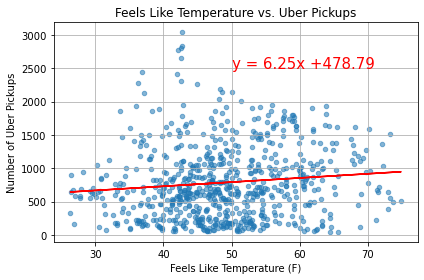

Correlation coeffecient [R-Value] is 0.11


<Figure size 432x288 with 0 Axes>

In [61]:
# Okay making the linear regression
(slope, intercept, rvalue, _, _) = linregress(combined_df['Feels Like'], combined_df['Uber Pickups'])

# Making the best fit regression line
fit = slope*combined_df['Feels Like']+intercept

# Making the initial scatter plot Feels Like Temp vs. Uber Pickups
combined_df.plot.scatter( x = 'Feels Like', y = 'Uber Pickups', grid = True, alpha = 0.55)

# Slapping some labels on this bad boy.
plt.xlabel('Feels Like Temperature (F)')
plt.ylabel("Number of Uber Pickups")
plt.title('Feels Like Temperature vs. # Uber Pickups')

# Overlaying the best fit line onto the graph
plt.plot(combined_df['Feels Like'], fit ,"-", color = "red")

# Writing the equation for the line as well.
plt.annotate(f'y = {round(slope, 2)}x +{round(intercept, 2)}', [50, 2500], color = 'red', fontsize = 15)

# Some clean up stuff and presenting the correlation value. It's very weak.
plt.tight_layout()
plt.show()
print(f'Correlation coeffecient [R-Value] is {round(rvalue,2)}')

plt.tight_layout()
plt.show()

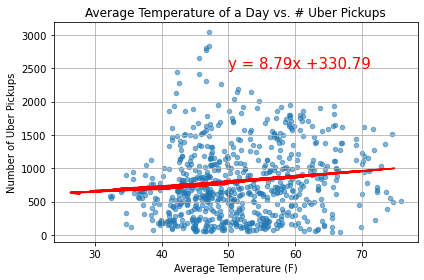

Correlation coeffecient [R-Value] is 0.14


<Figure size 432x288 with 0 Axes>

In [62]:
(slope, intercept, rvalue, _, _) = linregress(combined_df['Average Temperature'], combined_df['Uber Pickups'])
fit = slope*combined_df['Average Temperature']+intercept

combined_df.plot.scatter( x = 'Average Temperature', y = 'Uber Pickups', grid = True, alpha = 0.55)
plt.xlabel('Average Temperature (F)')
plt.ylabel("Number of Uber Pickups")
plt.title('Average Temperature of a Day vs. # Uber Pickups')

plt.plot(combined_df['Feels Like'], fit ,"-", color = "red")
plt.annotate(f'y = {round(slope, 2)}x +{round(intercept, 2)}', [50, 2500], color = 'red', fontsize = 15)

plt.tight_layout()
plt.show()
print(f'Correlation coeffecient [R-Value] is {round(rvalue,2)}')

plt.tight_layout()
plt.show()